<a href="https://colab.research.google.com/github/TMKarunarathne/FYP/blob/main/Spatio_15x15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Spatio-temporal 15x15**


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.io
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Flatten
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Conv2D,ConvLSTM2D,BatchNormalization,Conv3D, Conv1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate,Reshape
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
#from test_utils import summary, comparator
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

rand_state =1000

Mounted at /content/gdrive
Mounted at /content/gdrive


In [ ]:
#mat_file = '/content/gdrive/MyDrive/Data_Set/FV_10000x8928_01.mat'
#mat = scipy.io.loadmat(mat_file)

In [ ]:
#mat

In [ ]:
#mat('df')

In [ ]:
path = '/content/gdrive/MyDrive/Data_Set/FV_all_in_one.csv'
df = pd.read_csv(path)
df = df.drop(df.columns[[0]], axis=1)


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'] , unit="s")
#df.set_index(df['Datetime'] ,inplace=True)
#df = df.drop(df.columns[[0]], axis=1)
#df.head()

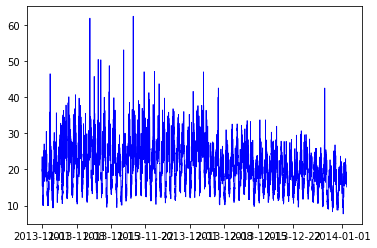

In [ ]:
cell_no = 4098 # select a cell
cell_data = df.iloc[:,cell_no]
plt.plot( df['Datetime'],cell_data ,color = 'blue', linewidth=0.8)

In [ ]:
dfdata = df.iloc[:,1:10001].to_numpy()
dfdata.shape

(8928, 10000)

In [ ]:
dd = dfdata[0:3,0:3]

In [ ]:
dd.reshape(-1)
dd

array([[11.02836638, 11.05822481, 11.09000792],
       [11.12710088, 11.16792632, 11.21138339],
       [10.8927706 , 10.91563796, 10.93997935]])

In [ ]:
arr3d = dfdata.reshape(8928, 100, 100)
#arr3d

In [ ]:
shapeData = arr3d.shape

In [ ]:
arr3d[1,0,0]

11.1271008756737

In [ ]:
numInps = 5
length = shapeData[0]

In [ ]:
ss = np.zeros((2,2))
ss[1,1]  = arr3d[1,0,0]
ss[1,1]

11.1271008756737

In [ ]:
def shapingInputs( arr3d , numInps ):
  shapeData = arr3d.shape
  X = np.zeros(( shapeData[0]-numInps , numInps , shapeData[1] , shapeData[2] ))
  Y = arr3d[numInps :]

  for i in range(0,shapeData[0]-numInps):
    X[i] = arr3d[i:i+numInps]

  return X/2000 , Y/2000

In [ ]:
X ,Y = shapingInputs( arr3d[:,40:55,40:55] , numInps )

In [ ]:
X.shape

(8923, 5, 15, 15)

In [ ]:
Y.shape

(8923, 15, 15)

In [ ]:
Y1 = Y.reshape(-1, 15, 15,1)
Y1.shape

(8923, 15, 15, 1)

### Trim 15x15 cells

In [ ]:
Xtrim = X[:,:,40:55,40:55]
Ytrim = Y1[:,40:55,40:55,:]
print(Xtrim.shape , Ytrim.shape)

(8923, 5, 0, 0) (8923, 0, 0, 1)


## **3D array was created...**

In [ ]:
# Make sure images have shape (28, 28, 1)
x_train = X.transpose((0,2,1,3))
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
#print(x_test.shape[0], "test samples")


x_train shape: (8923, 15, 5, 15)
8923 train samples


In [ ]:
#Z = arr3d[1,:,:]
Z = x_train[1,:,4,:]

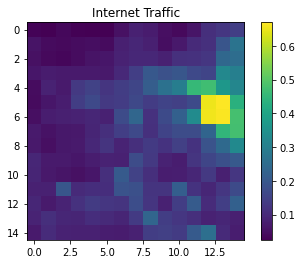

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Z)
plt.title("Internet Traffic")
plt.colorbar()
plt.show()


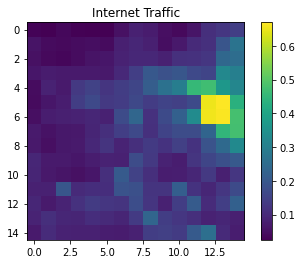

In [ ]:
Z1 = Y1[0,:,:,0]
plt.imshow(Z1)
plt.title("Internet Traffic")
plt.colorbar()
plt.show()

## **Move to CNN**

In [ ]:
def convBlock(X, f, filters, training=True, initializer=random_uniform):
    
    F1, F2 = filters
    
    # First component of main path
    X = Reshape((15,15,1))(X)

    X = Conv2D(filters = F1, kernel_size = 3, strides = 2, padding = 'valid', kernel_initializer = initializer(seed=0))(X) #7x7
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = 3, strides = 2, padding = 'valid', kernel_initializer = initializer(seed=0))(X)  #3x3
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    return X

In [ ]:
def MySpatio(input_shape = (15, 5, 15)):

    X_input = Input(input_shape)
    X1 = X_input[:,:,0]
    X2 = X_input[:,:,1]
    X3 = X_input[:,:,2]
    X4 = X_input[:,:,3]
    X5 = X_input[:,:,4]

    X1 = convBlock(X1, 3, [8, 8])
    X2 = convBlock(X2, 3, [8, 8])
    X3 = convBlock(X3, 3, [8, 8])
    X4 = convBlock(X4, 3, [8, 8])
    X5 = convBlock(X5, 3, [8, 8])

    X1 = Flatten()(X1)
    X2 = Flatten()(X2)
    X3 = Flatten()(X3)
    X4 = Flatten()(X4)
    X5 = Flatten()(X5)
    #print(X1.shape)

    X = concatenate([X1, X2, X3, X4, X5], axis=1 )
    #print(X.shape)

    X = Reshape((72,5))(X)
    #print(X.shape)

    X = LSTM(50, return_sequences=True)(X) 
    #print('Hi 1')
    #print(X.shape)
    X = LSTM(225)(X)
    #print('Hi 2')
    #print(X.shape)
    X = Reshape((15,15))(X)

    # The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = MySpatio(input_shape = (15,5,15))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 15, 5, 15)]  0           []                               
                                                                                                  
 tf.__operators__.getitem_190 (  (None, 15, 15)      0           ['input_39[0][0]']               
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_191 (  (None, 15, 15)      0           ['input_39[0][0]']               
 SlicingOpLambda)                                                                                 
                                                                                            

In [ ]:
x_train.shape

(8923, 15, 15, 5)

In [ ]:
#model.compile(loss="mse", optimizer="adam", metrics=["MeanAbsolutePercentageError"])
model.compile(loss="mse", optimizer="adam", metrics=["MeanSquaredError"])

In [ ]:
batch_size = 16
epochs = 5

In [ ]:
#model_cnn.fit( x_train, Y, batch_size=batch_size, epochs=epochs, validation_split=0.4)
#model_cnn.fit( x_train , Y1, batch_size=batch_size, epochs=epochs, validation_split=0.4)
model.fit( x_train , Y1, batch_size=batch_size, epochs=epochs, validation_split=0.4)

Epoch 1/5
335/335 [==============================] - 116s 291ms/step - loss: 9.7649e-04 - mean_squared_error: 9.7649e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2/5
335/335 [==============================] - 95s 285ms/step - loss: 9.5110e-04 - mean_squared_error: 9.5110e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/5
335/335 [==============================] - 98s 292ms/step - loss: 9.2080e-04 - mean_squared_error: 9.2080e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/5
335/335 [==============================] - 97s 288ms/step - loss: 9.0943e-04 - mean_squared_error: 9.0943e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 5/5
335/335 [==============================] - 95s 285ms/step - loss: 8.9423e-04 - mean_squared_error: 8.9423e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032


In [ ]:
#model.save('/content/gdrive/MyDrive/Data_Set/Spatio15x5_0218_01.model')
#model = tf.keras.models.load_model("/content/gdrive/MyDrive/Data_Set/Spatio15x5_0216_01.model")

In [ ]:
X.shape

(8923, 5, 15, 15)

In [ ]:
valPredict = model.predict(x_train[7200:720+7200])

23/23 [==============================] - 2s 80ms/step


In [ ]:
valPredict.shape

(720, 15, 15)

In [ ]:
Y.shape

(8923, 15, 15)

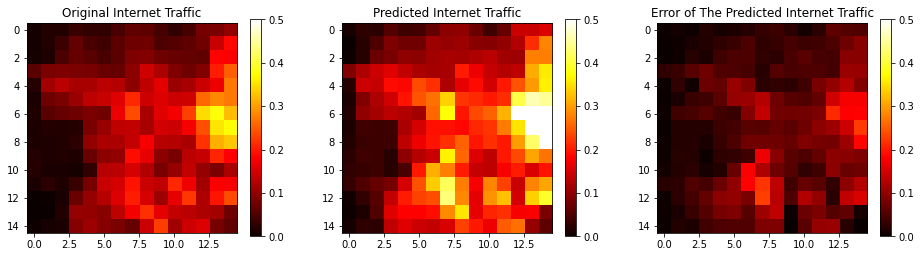

In [ ]:
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
Z1 = Y[7200,:,:]
plt.imshow(Z1,cmap="hot")
plt.title("Original Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
#plt.show()

plt.subplot(1, 3, 2)
Z2 = valPredict[0,:,:]
plt.imshow(Z2,cmap="hot")
plt.title("Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()

plt.subplot(1, 3, 3)
Z3 = Z2-Z1
plt.imshow(Z3,cmap="hot")
plt.title("Error of The Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
#plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spatio15x15_01_compare.png',transparent=True)
plt.show()



In [ ]:
print(Z3.max())

0.22922276003210956


In [ ]:
yout = Y[7200:7200 + valPredict.shape[0]]
print('pred shape = ',valPredict.shape)
print('Y shape = ',yout.shape)

pred shape =  (720, 15, 15)
Y shape =  (720, 15, 15)


In [ ]:
def absError(y , ypred):
  i = 1
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.absolute(ypred - y) , y))/(ypred.shape[1] * ypred.shape[2])/ypred.shape[0]
  return np.sum(dif)


def msep(y , ypred):
  i = 1
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.square(ypred - y) , np.square(y) ))/(ypred.shape[1] * ypred.shape[2])/ypred.shape[0]
  return np.sum(dif)

In [ ]:
print('Absolute percentage error is = ' , absError(yout , valPredict))
print('Absolute percentage mse is = ' , msep(yout , valPredict))

Absolute percentage error is =  0.5043607397101132
Absolute percentage mse is =  1.7211857945859659
